# Latest3edge RGCN Ensemble - Prediction & XAI Visualization

**Purpose:** Interactive notebook for antimicrobial activity prediction using Latest3edge 5-fold ensemble.

**Features:**
- 🎯 **Ensemble Prediction**: Averages predictions from all 5 trained models
- 🔍 **Ensemble Attribution**: Combines XAI explanations from all 5 models
- 🎨 **Visual XAI**: Highlights important substructures (blue = positive, orange = negative)
- 📊 **Quantitative Analysis**: Attribution scores and impact assessment

**Model Details:**
- Architecture: Latest3edge RGCN (aromatic edges filtered, 3-edge encoding)
- Training: 5-fold cross-validation ensemble
- XAI Method: Occlusion-based substructure masking
- Target: *S. aureus* antimicrobial classification

---

## 📌 How to Use

1. **Run Cell 1** (below) to load all models and setup *(takes ~30 seconds)*
2. **Go to Cell 2**, change the `smiles` variable to your molecule
3. **Run Cell 2** to get prediction + visualization

---

## Cell 1: Setup & Model Loading

*Run this cell once to initialize the ensemble. Warnings about model architecture are expected and safely ignored.*

⚠️ Model Checkpoint Compatibility Note

The provided model checkpoints were trained using an earlier implementation of the graph construction pipeline. The current scripts have been updated and are fully compatible with these legacy checkpoints. However, you may observe minor quantitative differences in attribution values (e.g., -0.31 vs -0.44) compared to the original training environment.

Important: The qualitative results remain consistent - attribution rankings, substructure importance patterns, and overall interpretations are preserved. Only the absolute magnitude of attribution scores may vary slightly.

For production use with new datasets, we recommend retraining models using the current codebase to ensure full numerical consistency.

In [2]:


import os
import sys
import glob
import io
import warnings
import logging
from typing import List, Dict, Optional

import torch
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display, HTML

from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from torch_geometric.data import Batch, Data
from torch_geometric.utils import subgraph as pyg_subgraph

# Import project modules
from model import BaseGNN
from build_data import construct_mol_graph_from_smiles, return_murcko_leaf_structure

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='.*num_edge_types.*')
warnings.filterwarnings('ignore', message='.*state_dict.*')

# Configure logging to suppress ALL messages except CRITICAL
logging.basicConfig(level=logging.CRITICAL, format='%(levelname)s: %(message)s')
# Silence all loggers from imported modules
for logger_name in ['config', 'model', 'build_data']:
    logging.getLogger(logger_name).setLevel(logging.CRITICAL)
log = logging.getLogger('latest3edge-ensemble')

print('🔧 Initializing Latest3edge Ensemble...')
print('━' * 80)

# ============================================================================
# Helper Functions
# ============================================================================

class _MinimalConfig:
    """Minimal config for model loading"""
    def __init__(self, in_dim: int, num_edge_types: int = 3, classification: bool = True):
        self.num_node_features = in_dim
        self.num_edge_types = num_edge_types
        self.classification = classification

def _ensure_batch(graph):
    """Ensure graph has batch attribute for model readout"""
    if not hasattr(graph, 'batch') or graph.batch is None:
        graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long, device=graph.x.device)
    return graph

def find_checkpoints(n: int = 5, folder: str = 'model_checkpoints') -> List[str]:
    """Find model checkpoints"""
    paths = sorted(glob.glob(os.path.join(folder, '*.ckpt')))
    if len(paths) < n:
        print(f'⚠️  Found {len(paths)} checkpoints (expected {n})')
    return paths[:n]

# ============================================================================
# Ensemble Class with Full Ensemble Attribution
# ============================================================================

class Latest3edgeEnsemble:
    """
    Latest3edge 5-fold ensemble with ensemble prediction AND ensemble attribution.
    
    Key Features:
    - Ensemble Prediction: Averages predictions from all 5 models
    - Ensemble Attribution: Averages attributions from all 5 models per substructure
    - Occlusion XAI: Feature masking to measure substructure importance
    - Automatic compatibility with old (65-edge) and new (3-edge) checkpoints
    """
    
    def __init__(self, checkpoint_paths: List[str], threshold: float = 0.5, device: Optional[str] = None):
        self.device = torch.device(device if device else ('cuda' if torch.cuda.is_available() else 'cpu'))
        self.threshold = threshold
        self.checkpoint_paths = checkpoint_paths
        self.models: List[BaseGNN] = []
        self.model_feature_dims: List[int] = []
        self.model_edge_types: List[int] = []
        
        # Redirect stdout temporarily to suppress model initialization messages
        import sys
        from io import StringIO
        old_stdout = sys.stdout
        sys.stdout = StringIO()
        
        # Load all 5 models
        for i, path in enumerate(checkpoint_paths, 1):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ckpt = torch.load(path, map_location=self.device, weights_only=False)
                
                if 'state_dict' not in ckpt or 'hyperparameters' not in ckpt:
                    sys.stdout = old_stdout
                    print(f'⚠️  Skipping invalid checkpoint: {os.path.basename(path)}')
                    sys.stdout = StringIO()
                    continue
                
                # Auto-detect input feature dimension AND num_edge_types from checkpoint weights
                in_dim = 12  # Default
                num_edge_types = 3  # Default for Latest3edge
                
                # Look for first RGCN layer weight to determine dimensions
                first_keys = [k for k in ckpt['state_dict'].keys() if 'rgcn_gnn_layers.0' in k and 'weight' in k]
                if first_keys:
                    w = ckpt['state_dict'][first_keys[0]]
                    if hasattr(w, 'shape') and len(w.shape) >= 3:
                        # RGCN weight shape: [num_edge_types, in_features, out_features]
                        num_edge_types = w.shape[0]
                        in_dim = w.shape[1]
                
                # Create config with auto-detected dimensions
                cfg = _MinimalConfig(in_dim, num_edge_types=num_edge_types)
                
                # Parse hyperparameters
                hp = ckpt['hyperparameters']
                rgcn_hidden_feats = hp.get('rgcn_hidden_feats', [256, 256])
                if isinstance(rgcn_hidden_feats, str):
                    rgcn_hidden_feats = [int(x) for x in rgcn_hidden_feats.replace('[','').replace(']','').replace('(','').replace(')','').replace(' ','').split('-' if '-' in rgcn_hidden_feats else ',') if x]
                
                ffn_hidden_feats = hp.get('ffn_hidden_feats', 64)
                if isinstance(ffn_hidden_feats, list):
                    ffn_hidden_feats = int(ffn_hidden_feats[0])
                else:
                    ffn_hidden_feats = int(ffn_hidden_feats)
                
                # Initialize model with auto-detected architecture
                model = BaseGNN(
                    config=cfg,
                    rgcn_hidden_feats=rgcn_hidden_feats,
                    ffn_hidden_feats=ffn_hidden_feats,
                    ffn_dropout=float(hp.get('ffn_dropout', 0.2)),
                    rgcn_dropout=float(hp.get('rgcn_dropout', 0.1)),
                    classification=True,
                    num_classes=2,
                )
                
                # Load state dict (should match perfectly now)
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    model.load_state_dict(ckpt['state_dict'], strict=True)
                
                model.eval().to(self.device)
                self.models.append(model)
                self.model_feature_dims.append(in_dim)
                self.model_edge_types.append(num_edge_types)
                
                # Restore stdout temporarily to show progress
                sys.stdout = old_stdout
                print(f'✓ Model {i}/5 loaded: {os.path.basename(path)}')
                sys.stdout = StringIO()
                
            except Exception as e:
                sys.stdout = old_stdout
                print(f'✗ Failed to load {os.path.basename(path)}: {str(e)[:100]}...')
                sys.stdout = StringIO()
                import traceback
                log.debug(traceback.format_exc())
        
        # Restore stdout
        sys.stdout = old_stdout
        
        if not self.models:
            raise RuntimeError('❌ No valid models loaded!')
        
        print(f'\n✅ Ensemble ready! Loaded {len(self.models)}/5 models on {self.device}')
        print('━' * 80)
        
        # Color scheme for visualization
        self.colors = {
            'positive': (0.0, 0.5, 1.0, 0.6),   # Blue (increases activity)
            'negative': (1.0, 0.5, 0.0, 0.6),   # Orange (decreases activity)
            'neutral':  (0.7, 0.7, 0.7, 0.4),   # Grey (minimal impact)
        }
    
    def _prepare_graph(self, smiles: str, feature_dim: int, smask: Optional[List[int]] = None):
        """Prepare molecular graph for prediction"""
        g = construct_mol_graph_from_smiles(smiles, smask=(smask or []))
        
        if g is None or not hasattr(g, 'x'):
            raise ValueError('Graph construction failed')
        
        # Ensure feature dimension matches model
        if g.x.shape[1] != feature_dim:
            x = g.x
            if x.shape[1] > feature_dim:
                x = x[:, :feature_dim].clone()
            else:
                new_x = torch.zeros((x.shape[0], feature_dim), device=x.device, dtype=x.dtype)
                new_x[:, :x.shape[1]] = x
                x = new_x
            g.x = x
        
        g = _ensure_batch(g).to(self.device)
        return g
    
    def predict(self, smiles: str) -> float:
        """Ensemble prediction (average of all models)"""
        preds = []
        
        for model, fdim in zip(self.models, self.model_feature_dims):
            try:
                g = self._prepare_graph(smiles, fdim, smask=[])
                batch = Batch.from_data_list([g])
                
                with torch.no_grad():
                    out, _ = model(batch)
                    p = torch.sigmoid(out).item()
                
                preds.append(p)
            except Exception as e:
                log.warning(f'Prediction error on a model: {e}')
        
        if not preds:
            raise RuntimeError('No valid predictions')
        
        return np.mean(preds)
    
    def analyze_attribution(self, smiles: str) -> List[Dict]:
        """
        Ensemble attribution analysis.
        
        For each substructure:
        1. Get base prediction (ensemble average)
        2. Get masked predictions from all models
        3. Average masked predictions (ensemble)
        4. Attribution = base_pred - masked_pred (ensemble level)
        """
        base_pred = self.predict(smiles)
        subs = return_murcko_leaf_structure(smiles).get('substructure', {})
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError('Invalid SMILES')
        
        results = []
        
        for key, atoms in subs.items():
            if not atoms:
                continue
            
            # Get masked predictions from all models (ENSEMBLE ATTRIBUTION)
            masked_preds = []
            
            for model, fdim in zip(self.models, self.model_feature_dims):
                try:
                    g_masked = self._prepare_graph(smiles, fdim, smask=atoms)
                    batch = Batch.from_data_list([g_masked])
                    
                    with torch.no_grad():
                        out, _ = model(batch)
                        p = torch.sigmoid(out).item()
                    
                    masked_preds.append(p)
                except Exception as e:
                    log.debug(f'Masked prediction error: {e}')
            
            if not masked_preds:
                continue
            
            # Ensemble masked prediction (average of all models)
            masked = np.mean(masked_preds)
            
            # Attribution = difference in ensemble predictions
            attr = base_pred - masked
            
            # Categorize impact
            if attr > 0.1:
                impact = 'Increases probability of activity'
                color = self.colors['positive']
            elif attr < -0.1:
                impact = 'Decreases probability of activity'
                color = self.colors['negative']
            else:
                impact = 'Minimal impact on activity'
                color = self.colors['neutral']
            
            sub_smiles = Chem.MolFragmentToSmiles(mol, atomsToUse=atoms, kekuleSmiles=True)
            
            results.append({
                'substructure': sub_smiles,
                'atoms': atoms,
                'attribution': float(attr),
                'impact': impact,
                'original_prediction': float(base_pred),
                'masked_prediction': float(masked),
                'class_change': (base_pred >= self.threshold) != (masked >= self.threshold),
                'color': color,
            })
        
        # Sort by absolute attribution (most important first)
        results.sort(key=lambda x: abs(x['attribution']), reverse=True)
        return results
    
    def visualize(self, smiles: str, results: List[Dict]) -> Dict[str, Image.Image]:
        """Generate molecular visualizations with highlighted substructures"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError('Invalid SMILES')
        
        if mol.GetNumConformers() == 0:
            rdDepictor.Compute2DCoords(mol)
        
        imgs = {}
        
        # Original molecule (no highlighting)
        drawer = rdMolDraw2D.MolDraw2DCairo(800, 600)
        opts = drawer.drawOptions()
        opts.addAtomIndices = False
        opts.bondLineWidth = 2.5
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        imgs['original'] = Image.open(io.BytesIO(drawer.GetDrawingText()))
        
        # Combined view: all substructures colored by attribution
        if results:
            atom_colors = {}
            bond_colors = {}
            
            for r in results:
                atoms = r['atoms']
                col = r['color']
                
                for a in atoms:
                    atom_colors[a] = col
                
                # Highlight bonds within substructure
                for i in range(len(atoms)):
                    for j in range(i+1, len(atoms)):
                        b = mol.GetBondBetweenAtoms(atoms[i], atoms[j])
                        if b:
                            bond_colors[b.GetIdx()] = col
            
            drawer = rdMolDraw2D.MolDraw2DCairo(800, 600)
            opts = drawer.drawOptions()
            opts.addAtomIndices = False
            opts.bondLineWidth = 2.5
            opts.highlightBondWidthMultiplier = 6
            
            drawer.DrawMolecule(
                mol,
                highlightAtoms=list(atom_colors.keys()),
                highlightBonds=list(bond_colors.keys()),
                highlightAtomColors=atom_colors,
                highlightBondColors=bond_colors
            )
            drawer.FinishDrawing()
            imgs['xai_combined'] = Image.open(io.BytesIO(drawer.GetDrawingText()))
        
        return imgs

# ============================================================================
# Load Ensemble (automatically finds all 5 checkpoints)
# ============================================================================

checkpoint_paths = find_checkpoints(5, 'model_checkpoints')
ensemble = Latest3edgeEnsemble(checkpoint_paths, threshold=0.5)

print('\n🎉 Setup complete! Ready for predictions.')
print('📝 Go to Cell 2 below and change the SMILES variable to predict your molecule.')
print('━' * 80)


2025-11-23 14:38:41 - INFO - model - Initialized for classification with 2 classes
INFO: Initialized for classification with 2 classes
INFO: Initialized for classification with 2 classes


🔧 Initializing Latest3edge Ensemble...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Model 1/5 loaded: S_aureus_classification_cv1_fold1_best.ckpt


2025-11-23 14:38:41 - INFO - model - Initialized for classification with 2 classes
INFO: Initialized for classification with 2 classes
INFO: Initialized for classification with 2 classes
2025-11-23 14:38:42 - INFO - model - Initialized for classification with 2 classes
2025-11-23 14:38:42 - INFO - model - Initialized for classification with 2 classes


✓ Model 2/5 loaded: S_aureus_classification_cv2_fold4_best.ckpt


INFO: Initialized for classification with 2 classes
2025-11-23 14:38:42 - INFO - model - Initialized for classification with 2 classes
2025-11-23 14:38:42 - INFO - model - Initialized for classification with 2 classes


✓ Model 3/5 loaded: S_aureus_classification_cv3_fold2_best.ckpt


INFO: Initialized for classification with 2 classes


✓ Model 4/5 loaded: S_aureus_classification_cv4_fold3_best.ckpt


2025-11-23 14:38:42 - INFO - model - Initialized for classification with 2 classes
INFO: Initialized for classification with 2 classes
INFO: Initialized for classification with 2 classes


✓ Model 5/5 loaded: S_aureus_classification_cv5_fold2_best.ckpt

✅ Ensemble ready! Loaded 5/5 models on cpu
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🎉 Setup complete! Ready for predictions.
📝 Go to Cell 2 below and change the SMILES variable to predict your molecule.
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


---

## Cell 2: User Input - Change SMILES Here

*Edit the `smiles` variable below and run this cell to get prediction + XAI visualization.*



════════════════════════════════════════════════════════════════════════════════
🔬 LATEST3EDGE ENSEMBLE PREDICTION & XAI
════════════════════════════════════════════════════════════════════════════════

📋 Input SMILES:
   CCOC(=O)CN1CCN(C2=C(F)C=C3C(=O)C(C(=O)O)=CN(C4CC4)C3=C2OC)CC1C

────────────────────────────────────────────────────────────────────────────────

🎯 ENSEMBLE PREDICTION:
   Class:        ACTIVE
   Probability:  0.8069
   Confidence:   80.7%
   Threshold:    0.5

────────────────────────────────────────────────────────────────────────────────
🔍 ENSEMBLE XAI ANALYSIS (Occlusion-based):
   Analyzing substructure importance across all 5 models...

🎯 ENSEMBLE PREDICTION:
   Class:        ACTIVE
   Probability:  0.8069
   Confidence:   80.7%
   Threshold:    0.5

────────────────────────────────────────────────────────────────────────────────
🔍 ENSEMBLE XAI ANALYSIS (Occlusion-based):
   Analyzing substructure importance across all 5 models...

📊 Top Substructures by Attrib

,Rank,Substructure,Attribution,Impact,Class Change
0,1,O=C1C=CNC2=CC=C(F)C=C12,+0.638,Increases probability of activity,✓
1,2,O=CO,+0.552,Increases probability of activity,✓
2,3,CC1CNCCN1,+0.531,Increases probability of activity,✓
3,4,C1CC1,+0.185,Increases probability of activity,✗
4,5,O,-0.042,Minimal impact on activity,✗
5,6,CC,+0.037,Minimal impact on activity,✗
6,7,CO,-0.024,Minimal impact on activity,✗
7,8,CC=O,+0.005,Minimal impact on activity,✗



📖 Legend:
   Attribution:  Change in probability when substructure is masked
                 Positive = increases activity | Negative = decreases activity
   Class Change: Whether masking changes the predicted class (Active ↔ Inactive)

────────────────────────────────────────────────────────────────────────────────
🎨 MOLECULAR VISUALIZATIONS:

1️⃣ Original Molecule:


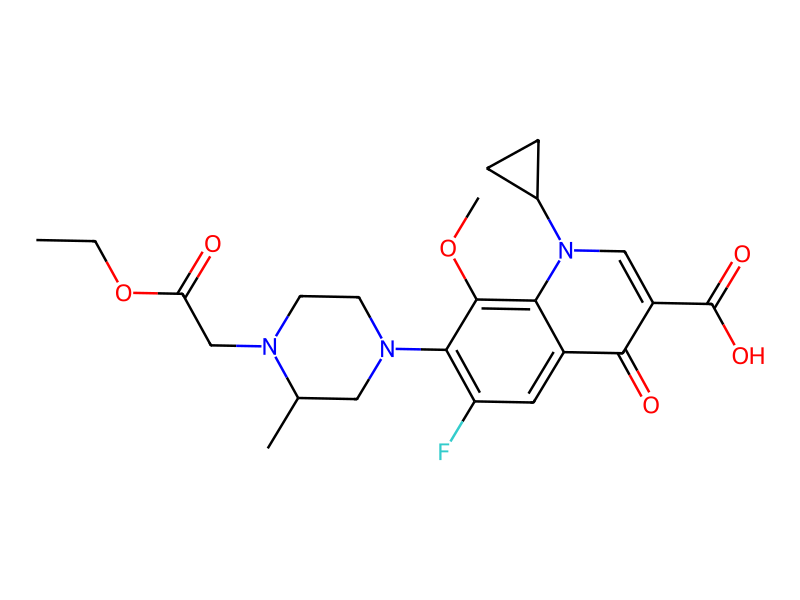


2️⃣ XAI Highlighted (Ensemble Attribution):
   🔵 Blue = Positive attribution (increases activity)
   🟠 Orange = Negative attribution (decreases activity)
   ⚪ Grey = Minimal impact



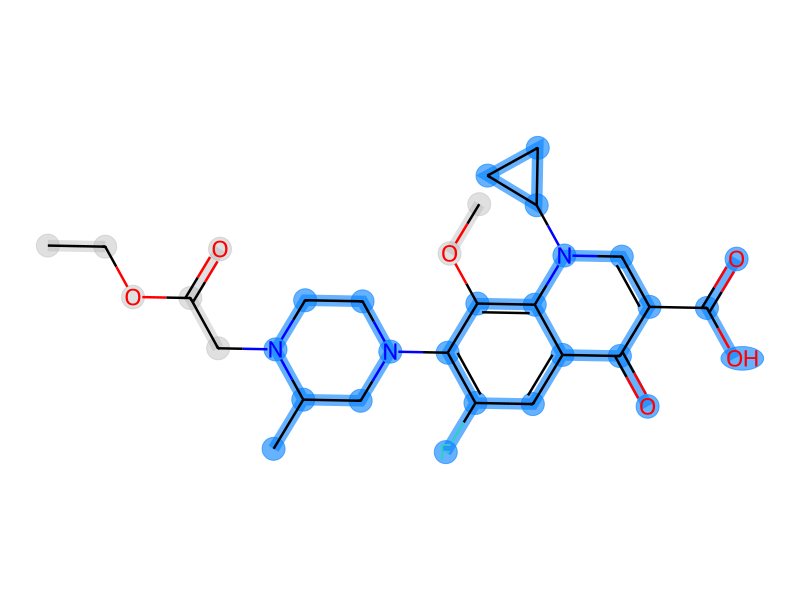


────────────────────────────────────────────────────────────────────────────────
📈 SUMMARY STATISTICS:
   Total substructures analyzed:     8
   Positive attributions (> +0.1):   4
   Negative attributions (< -0.1):   0
   Neutral attributions (± 0.1):     4
   Substructures causing class flip: 3

════════════════════════════════════════════════════════════════════════════════
✅ Analysis Complete!
════════════════════════════════════════════════════════════════════════════════


In [4]:
# ============================================================================

# ────────────────────────────────────────────────────────────────────────────
# 📝 EDIT THIS LINE - Enter your SMILES string:
# ────────────────────────────────────────────────────────────────────────────

smiles = 'CCOC(=O)CN1CCN(C2=C(F)C=C3C(=O)C(C(=O)O)=CN(C4CC4)C3=C2OC)CC1C'  # Example SMILES



# ============================================================================
# PREDICTION & XAI ANALYSIS
# ============================================================================

print('\n' + '═' * 80)
print('🔬 LATEST3EDGE ENSEMBLE PREDICTION & XAI')
print('═' * 80)
print(f'\n📋 Input SMILES:')
print(f'   {smiles}')
print('\n' + '─' * 80)

# Ensemble Prediction
try:
    prob = ensemble.predict(smiles)
    label = 'ACTIVE' if prob >= ensemble.threshold else 'INACTIVE'
    confidence = prob if prob >= 0.5 else (1 - prob)
    
    print(f'\n🎯 ENSEMBLE PREDICTION:')
    print(f'   Class:        {label}')
    print(f'   Probability:  {prob:.4f}')
    print(f'   Confidence:   {confidence:.1%}')
    print(f'   Threshold:    {ensemble.threshold}')
    
    # Ensemble Attribution Analysis
    print('\n' + '─' * 80)
    print('🔍 ENSEMBLE XAI ANALYSIS (Occlusion-based):')
    print('   Analyzing substructure importance across all 5 models...')
    
    results = ensemble.analyze_attribution(smiles)
    
    if results:
        # Create results table
        df = pd.DataFrame([{
            'Rank': i + 1,
            'Substructure': r['substructure'][:50] + '...' if len(r['substructure']) > 50 else r['substructure'],
            'Attribution': f"{r['attribution']:+.3f}",
            'Impact': r['impact'],
            'Class Change': '✓' if r['class_change'] else '✗',
        } for i, r in enumerate(results[:10])])  # Top 10 substructures
        
        print('\n📊 Top Substructures by Attribution (Ensemble Average):')
        print('')
        display(df)
        
        # Legend
        print('\n📖 Legend:')
        print('   Attribution:  Change in probability when substructure is masked')
        print('                 Positive = increases activity | Negative = decreases activity')
        print('   Class Change: Whether masking changes the predicted class (Active ↔ Inactive)')
        
        # Generate visualizations
        print('\n' + '─' * 80)
        print('🎨 MOLECULAR VISUALIZATIONS:')
        
        viz = ensemble.visualize(smiles, results)
        
        if 'original' in viz:
            print('\n1️⃣ Original Molecule:')
            display(viz['original'])
        
        if 'xai_combined' in viz:
            print('\n2️⃣ XAI Highlighted (Ensemble Attribution):')
            print('   🔵 Blue = Positive attribution (increases activity)')
            print('   🟠 Orange = Negative attribution (decreases activity)')
            print('   ⚪ Grey = Minimal impact')
            print('')
            display(viz['xai_combined'])
        
        # Summary statistics
        print('\n' + '─' * 80)
        print('📈 SUMMARY STATISTICS:')
        print(f'   Total substructures analyzed:     {len(results)}')
        print(f'   Positive attributions (> +0.1):   {sum(1 for r in results if r["attribution"] > 0.1)}')
        print(f'   Negative attributions (< -0.1):   {sum(1 for r in results if r["attribution"] < -0.1)}')
        print(f'   Neutral attributions (± 0.1):     {sum(1 for r in results if abs(r["attribution"]) <= 0.1)}')
        print(f'   Substructures causing class flip: {sum(1 for r in results if r["class_change"])}')
        
    else:
        print('   ⚠️  No substructures identified for this molecule.')
    
    print('\n' + '═' * 80)
    print('✅ Analysis Complete!')
    print('═' * 80)

except Exception as e:
    print(f'\n❌ ERROR: {e}')
    print('\nPlease check:')
    print('  1. SMILES string is valid')
    print('  2. Cell 1 was run successfully')
    print('  3. All 5 model checkpoints are in model_checkpoints/ directory')
    import traceback
    traceback.print_exc()